In [3]:

!pip install -q transformers datasets accelerate evaluate sentencepiece scikit-learn matplotlib seaborn imbalanced-learn


In [4]:

import torch, sys, os
print("Python:", sys.version.splitlines()[0])
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    try:
        print("GPU name:", torch.cuda.get_device_name(0))
    except Exception as e:
        print("Couldn't get GPU name:", e)
else:
    print("No GPU detected. Use Runtime → Change runtime type → GPU (T4).")

!nvidia-smi || true


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Torch version: 2.8.0+cu126
CUDA available: True
GPU name: Tesla T4
Wed Oct  1 06:22:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             34W /   70W |    2974MiB /  15360MiB |      0%      Default |
|             

In [5]:

import os
from google.colab import files
EMAIL_PATH = "/content/email_data.csv"
URL_PATH   = "/content/url_data.csv"

if os.path.exists(EMAIL_PATH) and os.path.exists(URL_PATH):
    print("Found datasets at /mnt/data/")
else:
    print("Files not found at /mnt/data. Please upload email_data.csv and url_data.csv when prompted.")
    uploaded = files.upload()
    for fname in uploaded:
        open(fname, 'wb').write(uploaded[fname])

    if os.path.exists("email_data.csv"):
        EMAIL_PATH = "email_data.csv"
    if os.path.exists("url_data.csv"):
        URL_PATH = "url_data.csv"

import pandas as pd
email_df = pd.read_csv(EMAIL_PATH)
url_df   = pd.read_csv(URL_PATH)
print("Email shape:", email_df.shape)
print("URL shape:", url_df.shape)
print("\nEmail columns:", email_df.columns.tolist()[:30])
print("URL columns:", url_df.columns.tolist()[:50])


display(email_df.head(3))
display(url_df.head(3))


Found datasets at /mnt/data/
Email shape: (5171, 4)
URL shape: (11430, 89)

Email columns: ['Unnamed: 0', 'label', 'text', 'label_num']
URL columns: ['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service', 'path_extension', 'nb_redirection', 'nb_external_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host']


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0


,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing


In [6]:

assert 'text' in email_df.columns, "Email CSV must contain 'text' column"
assert 'label_num' in email_df.columns, "Email CSV must contain 'label_num' column"
assert 'url' in url_df.columns, "URL CSV must contain 'url' column"
assert 'status' in url_df.columns, "URL CSV must contain 'status' column"


email_df = email_df[['text','label_num']].rename(columns={'label_num':'label'})

email_df['label'] = email_df['label'].astype(int).map(lambda x: 1 if x != 0 else 0)

url_df = url_df.copy()
def map_status(s):
    s = str(s).strip().lower()
    return 1 if 'phish' in s or 'malicious' in s or 'bad' in s else 0
url_df['label'] = url_df['status'].map(map_status)

url_df = url_df[['url','label'] + [c for c in url_df.columns if c not in ['url','status','label']]]

url_df = url_df.rename(columns={'url':'text'})

print("Email class counts:\n", email_df['label'].value_counts())
print("URL class counts:\n", url_df['label'].value_counts())

display(email_df.head(2))
display(url_df.head(2))


Email class counts:
 label
0    3672
1    1499
Name: count, dtype: int64
URL class counts:
 label
0    5715
1    5715
Name: count, dtype: int64


,text,label
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0


,text,label,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
0,http://www.crestonwood.com/router.php,0,37,19,0,3,0,0,0,0,...,0,0,1,0,45,-1,0,1,1,4
1,http://shadetreetechnology.com/V4/validation/a...,1,77,23,1,1,0,0,0,0,...,0,1,0,0,77,5767,0,0,1,2


In [7]:

from sklearn.model_selection import train_test_split
RANDOM_SEED = 42

def make_splits(df, test_size=0.1, val_size=0.1, seed=RANDOM_SEED):
    trainval, test = train_test_split(df, test_size=test_size, stratify=df['label'], random_state=seed)
    train, val = train_test_split(trainval, test_size=val_size/(1-test_size), stratify=trainval['label'], random_state=seed)
    return train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)

email_train, email_val, email_test = make_splits(email_df, test_size=0.1, val_size=0.1)
url_train, url_val, url_test       = make_splits(url_df,   test_size=0.1, val_size=0.1)

print("Email splits:", email_train.shape, email_val.shape, email_test.shape)
print("URL splits:", url_train.shape, url_val.shape, url_test.shape)


Email splits: (4136, 2) (517, 2) (518, 2)
URL splits: (9144, 89) (1143, 89) (1143, 89)


In [8]:

import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

def print_metrics(y_true, y_pred, target_names=['legit','phish']):
    print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.show()

def compute_metrics_sklearn(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    return {'accuracy': acc, 'precision': p, 'recall': r, 'f1': f1}


In [9]:

ros = RandomOverSampler(random_state=RANDOM_SEED)

def train_baselines_text(train_df, val_df, analyzer='word', ngram_range=(1,3), max_feat=20000):
    X_train, y_train = train_df['text'].values, train_df['label'].values
    X_val, y_val     = val_df['text'].values, val_df['label'].values

    pipe_lr = Pipeline([
        ('tfidf', TfidfVectorizer(analyzer=analyzer, ngram_range=ngram_range, max_features=max_feat)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_SEED))
    ])
    pipe_lr.fit(X_train, y_train)
    y_pred_lr = pipe_lr.predict(X_val)
    lr_metrics = compute_metrics_sklearn(y_val, y_pred_lr)


    pipe_rf = Pipeline([
        ('tfidf', TfidfVectorizer(analyzer=analyzer, ngram_range=ngram_range, max_features=int(max_feat/2))),
        ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_SEED, n_jobs=-1))
    ])
    pipe_rf.fit(X_train, y_train)
    y_pred_rf = pipe_rf.predict(X_val)
    rf_metrics = compute_metrics_sklearn(y_val, y_pred_rf)

    return {'logreg':(pipe_lr, lr_metrics, y_val, y_pred_lr), 'rf':(pipe_rf, rf_metrics, y_val, y_pred_rf)}

print("Training email baselines (this may take ~1-2 minutes depending on dataset size)...")
email_baseline_results = train_baselines_text(email_train, email_val, analyzer='word', ngram_range=(1,3), max_feat=20000)
print("Email LR:", email_baseline_results['logreg'][1])
print("Email RF:", email_baseline_results['rf'][1])


Training email baselines (this may take ~1-2 minutes depending on dataset size)...
Email LR: {'accuracy': 0.9787234042553191, 'precision': 0.9371069182389937, 'recall': 0.9933333333333333, 'f1': 0.9644012944983819}
Email RF: {'accuracy': 0.9806576402321083, 'precision': 0.9605263157894737, 'recall': 0.9733333333333334, 'f1': 0.9668874172185431}


In [10]:

print("Training URL baselines (char n-grams) ...")
url_baseline_results = train_baselines_text(url_train, url_val, analyzer='char_wb', ngram_range=(3,7), max_feat=20000)
print("URL LR:", url_baseline_results['logreg'][1])
print("URL RF:", url_baseline_results['rf'][1])


Training URL baselines (char n-grams) ...
URL LR: {'accuracy': 0.9037620297462817, 'precision': 0.9081272084805654, 'recall': 0.8986013986013986, 'f1': 0.9033391915641477}
URL RF: {'accuracy': 0.8976377952755905, 'precision': 0.8956521739130435, 'recall': 0.9003496503496503, 'f1': 0.8979947689625108}


=== EMAIL: Logistic Regression ===
              precision    recall  f1-score   support

         ham       1.00      0.97      0.98       367
        spam       0.94      0.99      0.96       150

    accuracy                           0.98       517
   macro avg       0.97      0.98      0.97       517
weighted avg       0.98      0.98      0.98       517



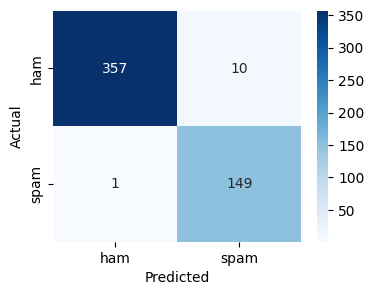

=== EMAIL: Random Forest ===
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       367
        spam       0.96      0.97      0.97       150

    accuracy                           0.98       517
   macro avg       0.97      0.98      0.98       517
weighted avg       0.98      0.98      0.98       517



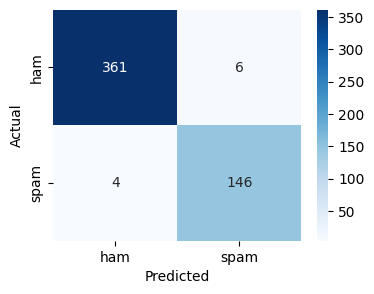

=== URL: Logistic Regression ===
              precision    recall  f1-score   support

       legit       0.90      0.91      0.90       571
       phish       0.91      0.90      0.90       572

    accuracy                           0.90      1143
   macro avg       0.90      0.90      0.90      1143
weighted avg       0.90      0.90      0.90      1143



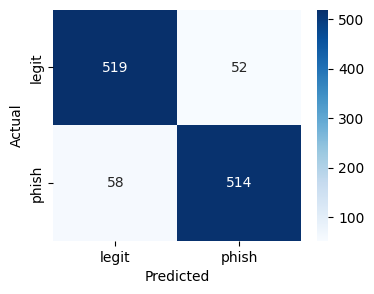

=== URL: Random Forest ===
              precision    recall  f1-score   support

       legit       0.90      0.89      0.90       571
       phish       0.90      0.90      0.90       572

    accuracy                           0.90      1143
   macro avg       0.90      0.90      0.90      1143
weighted avg       0.90      0.90      0.90      1143



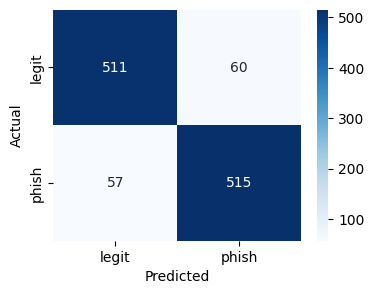

In [11]:

print("=== EMAIL: Logistic Regression ===")
print_metrics(email_baseline_results['logreg'][2], email_baseline_results['logreg'][3], target_names=['ham','spam'])
print("=== EMAIL: Random Forest ===")
print_metrics(email_baseline_results['rf'][2], email_baseline_results['rf'][3], target_names=['ham','spam'])

print("=== URL: Logistic Regression ===")
print_metrics(url_baseline_results['logreg'][2], url_baseline_results['logreg'][3], target_names=['legit','phish'])
print("=== URL: Random Forest ===")
print_metrics(url_baseline_results['rf'][2], url_baseline_results['rf'][3], target_names=['legit','phish'])


In [12]:

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
from datasets import Dataset

EMAIL_MODEL = "bert-base-uncased"
URL_MODEL   = "distilbert-base-uncased"

email_tokenizer = AutoTokenizer.from_pretrained(EMAIL_MODEL)
url_tokenizer   = AutoTokenizer.from_pretrained(URL_MODEL)

def to_hf(df):

    ds = Dataset.from_pandas(df[['text','label']].reset_index(drop=True))
    return ds

email_train_ds = to_hf(email_train)
email_val_ds   = to_hf(email_val)
email_test_ds  = to_hf(email_test)

url_train_ds = to_hf(url_train)
url_val_ds   = to_hf(url_val)
url_test_ds  = to_hf(url_test)


def tokenize_email(batch):
    return email_tokenizer(batch['text'], truncation=True, padding=False, max_length=256)
def tokenize_url(batch):
    return url_tokenizer(batch['text'], truncation=True, padding=False, max_length=128)

email_train_ds = email_train_ds.map(tokenize_email, batched=True)
email_val_ds   = email_val_ds.map(tokenize_email, batched=True)
email_test_ds  = email_test_ds.map(tokenize_email, batched=True)

url_train_ds = url_train_ds.map(tokenize_url, batched=True)
url_val_ds   = url_val_ds.map(tokenize_url, batched=True)
url_test_ds  = url_test_ds.map(tokenize_url, batched=True)


email_train_ds.set_format(type='torch', columns=['input_ids','attention_mask','label'])
email_val_ds.set_format(type='torch', columns=['input_ids','attention_mask','label'])
email_test_ds.set_format(type='torch', columns=['input_ids','attention_mask','label'])

url_train_ds.set_format(type='torch', columns=['input_ids','attention_mask','label'])
url_val_ds.set_format(type='torch', columns=['input_ids','attention_mask','label'])
url_test_ds.set_format(type='torch', columns=['input_ids','attention_mask','label'])

email_data_collator = DataCollatorWithPadding(tokenizer=email_tokenizer)
url_data_collator   = DataCollatorWithPadding(tokenizer=url_tokenizer)

print("Tokenization complete.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/4136 [00:00<?, ? examples/s]

Map:   0%|          | 0/517 [00:00<?, ? examples/s]

Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/9144 [00:00<?, ? examples/s]

Map:   0%|          | 0/1143 [00:00<?, ? examples/s]

Map:   0%|          | 0/1143 [00:00<?, ? examples/s]

Tokenization complete.


In [13]:

import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics_trainer(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    return {'accuracy': acc, 'precision': p, 'recall': r, 'f1': f1}


In [14]:
!pip install --upgrade transformers


In [15]:

device = 0 if torch.cuda.is_available() else -1
print("Using GPU:", torch.cuda.is_available())

email_model = AutoModelForSequenceClassification.from_pretrained(
    EMAIL_MODEL, num_labels=2
)

email_training_args = TrainingArguments(
    output_dir="./email_bert",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    logging_dir="./logs/email",
    save_total_limit=2,
    seed=RANDOM_SEED
)

email_trainer = Trainer(
    model=email_model,
    args=email_training_args,
    train_dataset=email_train_ds,
    eval_dataset=email_val_ds,
    tokenizer=email_tokenizer,
    data_collator=email_data_collator,
    compute_metrics=compute_metrics_trainer
)

print("Starting BERT fine-tuning on email (this can take several minutes)...")
email_trainer.train()
email_eval = email_trainer.evaluate(email_test_ds)
print("Email test eval:", email_eval)


Using GPU: True


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1315659478.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  email_trainer = Trainer(


Starting BERT fine-tuning on email (this can take several minutes)...


wandb: Currently logged in as: jaisubiksha2006 (jaisubiksha2006-nigesh-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.071600


Email test eval: {'eval_loss': 0.02532520703971386, 'eval_accuracy': 0.9942084942084942, 'eval_precision': 1.0, 'eval_recall': 0.98, 'eval_f1': 0.98989898989899, 'eval_runtime': 2.0467, 'eval_samples_per_second': 253.095, 'eval_steps_per_second': 8.306, 'epoch': 2.0}


In [16]:

device = 0 if torch.cuda.is_available() else -1
print("Using GPU:", torch.cuda.is_available())


url_model = AutoModelForSequenceClassification.from_pretrained(URL_MODEL, num_labels=2)


url_training_args = TrainingArguments(
    output_dir="./url_bert",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    logging_dir="./logs/url",
    save_total_limit=2,
    seed=RANDOM_SEED
)


url_trainer = Trainer(
    model=url_model,
    args=url_training_args,
    train_dataset=url_train_ds,
    eval_dataset=url_val_ds,
    tokenizer=url_tokenizer,
    data_collator=url_data_collator,
    compute_metrics=compute_metrics_trainer
)

print("Starting BERT fine-tuning on URL (this can take several minutes)...")
url_trainer.train()
url_eval = url_trainer.evaluate(url_test_ds)
print("URL test eval:", url_eval)


Using GPU: True


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2428766287.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  url_trainer = Trainer(


Starting BERT fine-tuning on URL (this can take several minutes)...


Step,Training Loss
500,0.264700
1000,0.135700


URL test eval: {'eval_loss': 0.11355622857809067, 'eval_accuracy': 0.9667541557305337, 'eval_precision': 0.9700176366843033, 'eval_recall': 0.9632224168126094, 'eval_f1': 0.9666080843585237, 'eval_runtime': 0.9551, 'eval_samples_per_second': 1196.719, 'eval_steps_per_second': 37.692, 'epoch': 2.0}


=== BERT (email) report ===


              precision    recall  f1-score   support

         ham       1.00      1.00      1.00       368
        spam       1.00      0.99      1.00       150

    accuracy                           1.00       518
   macro avg       1.00      1.00      1.00       518
weighted avg       1.00      1.00      1.00       518



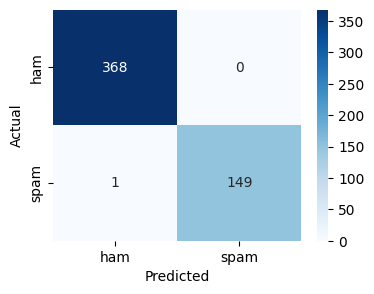

=== DistilBERT (url) report ===


              precision    recall  f1-score   support

       legit       0.96      0.97      0.97       572
       phish       0.97      0.96      0.97       571

    accuracy                           0.97      1143
   macro avg       0.97      0.97      0.97      1143
weighted avg       0.97      0.97      0.97      1143



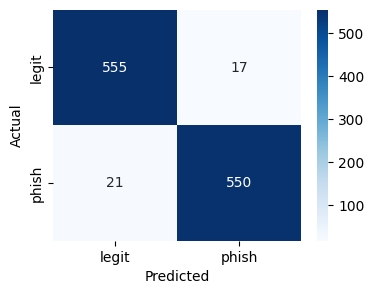

In [30]:

def get_preds_and_report(trainer, dataset, labels=['legit','phish']):
    pred_result = trainer.predict(dataset)
    logits = pred_result.predictions
    y_pred = np.argmax(logits, axis=1)
    y_true = pred_result.label_ids
    y_prob = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    print_metrics(y_true, y_pred, target_names=labels)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    return {'accuracy':acc, 'precision':p, 'recall':r, 'f1':f1, 'y_pred': y_pred, 'y_true': y_true, 'y_prob': y_prob}

print("=== BERT (email) report ===")
email_metrics = get_preds_and_report(email_trainer, email_test_ds, labels=['ham','spam'])
print("=== DistilBERT (url) report ===")
url_metrics   = get_preds_and_report(url_trainer, url_test_ds, labels=['legit','phish'])

In [19]:
from transformers import TrainingArguments, Trainer


small_grid = [
    {'learning_rate': 2e-5, 'per_device_train_batch_size': 16, 'num_train_epochs': 2},
    {'learning_rate': 3e-5, 'per_device_train_batch_size': 16, 'num_train_epochs': 2},
    {'learning_rate': 2e-5, 'per_device_train_batch_size': 32, 'num_train_epochs': 2},
]

for params in small_grid:
    print("Sweep params:", params)

    ta = TrainingArguments(
        output_dir="./temp_email_sweep",
        learning_rate=params['learning_rate'],
        per_device_train_batch_size=params['per_device_train_batch_size'],
        num_train_epochs=params['num_train_epochs'],
        fp16=torch.cuda.is_available(),
        logging_dir="./logs/temp_sweep",
        seed=RANDOM_SEED
    )

    sweep_trainer = Trainer(
        model=email_model,
        args=ta,
        train_dataset=email_train_ds,
        eval_dataset=email_val_ds,
        tokenizer=email_tokenizer,
        data_collator=email_data_collator,
        compute_metrics=compute_metrics_trainer
    )

    sweep_trainer.train()
    sweep_eval = sweep_trainer.evaluate(email_test_ds)
    print("Sweep evaluation:", sweep_eval)
    print("-" * 50)


Sweep params: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2}


/tmp/ipython-input-153926385.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  sweep_trainer = Trainer(


Step,Training Loss
500,0.010100


Sweep evaluation: {'eval_loss': 0.029433563351631165, 'eval_accuracy': 0.9922779922779923, 'eval_precision': 1.0, 'eval_recall': 0.9733333333333334, 'eval_f1': 0.9864864864864865, 'eval_runtime': 2.1695, 'eval_samples_per_second': 238.765, 'eval_steps_per_second': 29.961, 'epoch': 2.0}
--------------------------------------------------
Sweep params: {'learning_rate': 3e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2}


/tmp/ipython-input-153926385.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  sweep_trainer = Trainer(


Step,Training Loss
500,0.015600


Sweep evaluation: {'eval_loss': 0.005363921634852886, 'eval_accuracy': 0.9961389961389961, 'eval_precision': 1.0, 'eval_recall': 0.9866666666666667, 'eval_f1': 0.9932885906040269, 'eval_runtime': 2.1402, 'eval_samples_per_second': 242.03, 'eval_steps_per_second': 30.371, 'epoch': 2.0}
--------------------------------------------------
Sweep params: {'learning_rate': 2e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2}


/tmp/ipython-input-153926385.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  sweep_trainer = Trainer(


Step,Training Loss


Sweep evaluation: {'eval_loss': 0.011507794260978699, 'eval_accuracy': 0.9980694980694981, 'eval_precision': 1.0, 'eval_recall': 0.9933333333333333, 'eval_f1': 0.9966555183946488, 'eval_runtime': 2.0997, 'eval_samples_per_second': 246.697, 'eval_steps_per_second': 30.956, 'epoch': 2.0}
--------------------------------------------------


In [21]:

email_trainer.save_model("./final_email_bert")
url_trainer.save_model("./final_url_distilbert")
print("Saved models to ./final_email_bert and ./final_url_distilbert")

from transformers import pipeline


email_clf = pipeline("text-classification", model="./final_email_bert", tokenizer="./final_email_bert", return_all_scores=False, device=0 if torch.cuda.is_available() else -1)
url_clf   = pipeline("text-classification", model="./final_url_distilbert", tokenizer="./final_url_distilbert", return_all_scores=False, device=0 if torch.cuda.is_available() else -1)


print(email_clf("Subject: please verify your account: click http://bad.example/login now"))
print(url_clf("http://update-secure-apple.com/login?user=1"))


Saved models to ./final_email_bert and ./final_url_distilbert


Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Device set to use cuda:0


[{'label': 'LABEL_1', 'score': 0.9999988079071045}]
[{'label': 'LABEL_1', 'score': 0.9933926463127136}]


,dataset,model,f1
0,email,logreg_tfidf,0.964401
1,email,rf_tfidf,0.966887
2,email,bert_finetuned,0.989899
3,url,logreg_tfidf,0.903339
4,url,rf_tfidf,0.897995
5,url,distilbert_finetuned,0.966608


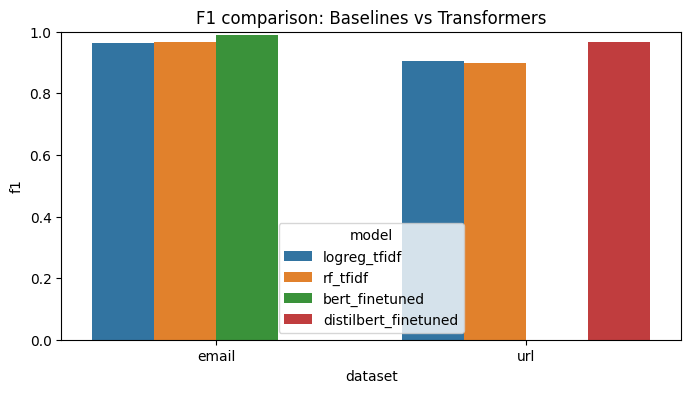

In [22]:

import pandas as pd
rows = []

rows.append({'dataset':'email','model':'logreg_tfidf','f1': email_baseline_results['logreg'][1]['f1']})
rows.append({'dataset':'email','model':'rf_tfidf','f1': email_baseline_results['rf'][1]['f1']})
rows.append({'dataset':'email','model':'bert_finetuned','f1': email_metrics['f1']})


rows.append({'dataset':'url','model':'logreg_tfidf','f1': url_baseline_results['logreg'][1]['f1']})
rows.append({'dataset':'url','model':'rf_tfidf','f1': url_baseline_results['rf'][1]['f1']})
rows.append({'dataset':'url','model':'distilbert_finetuned','f1': url_metrics['f1']})

summary_df = pd.DataFrame(rows)
display(summary_df)
plt.figure(figsize=(8,4))
sns.barplot(data=summary_df, x='dataset', y='f1', hue='model')
plt.ylim(0,1)
plt.title("F1 comparison: Baselines vs Transformers")
plt.show()


In [24]:
print(email_test_ds.column_names)


['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


In [34]:

import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score


os.makedirs("outputs", exist_ok=True)


def plot_cm(y_true, y_pred, labels, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.savefig(filename)
    plt.close()

def plot_f1_comparison(df, filename):
    plt.figure(figsize=(8,5))
    sns.barplot(x='model', y='f1', hue='dataset', data=df)
    plt.ylim(0,1)
    plt.title("F1 Score Comparison")
    plt.ylabel("F1 Score")
    plt.savefig(filename)
    plt.close()


def plot_training_history_corrected(history, title, filename):
    train_losses = []
    eval_losses = []

    for entry in history:
        if 'loss' in entry:
            train_losses.append(entry['loss'])
        if 'eval_loss' in entry:
            eval_losses.append(entry['eval_loss'])

    if len(train_losses) == 0 or len(eval_losses) == 0:
        print(f"Warning: No train or eval loss found for {title}")
        return

    if len(eval_losses) < len(train_losses):
        eval_losses = [eval_losses[0]]*(len(train_losses)-len(eval_losses)) + eval_losses

    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(eval_losses, label="Eval Loss")
    plt.title(title)
    plt.xlabel("Step / Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(filename)
    plt.close()


def plot_roc(y_true, y_prob, labels, title, filename):
    plt.figure(figsize=(7,6))
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    if y_prob.ndim == 1:
        y_prob = np.vstack([1-y_prob, y_prob]).T
    for i, label in enumerate(labels):
        fpr, tpr, _ = roc_curve((y_true==i).astype(int), y_prob[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.close()


email_test_labels = np.array(email_test_ds['label'])
url_test_labels = np.array(url_test_ds['label'])


email_preds = np.array(email_trainer.predict(email_test_ds).predictions.argmax(axis=1))
email_probs = torch.nn.functional.softmax(torch.tensor(email_trainer.predict(email_test_ds).predictions), dim=1).numpy()

url_preds = np.array(url_trainer.predict(url_test_ds).predictions.argmax(axis=1))
url_probs = torch.nn.functional.softmax(torch.tensor(url_trainer.predict(url_test_ds).predictions), dim=1).numpy()

email_metrics = {
    'accuracy': accuracy_score(email_test_labels, email_preds),
    'precision': precision_score(email_test_labels, email_preds),
    'recall': recall_score(email_test_labels, email_preds),
    'f1': f1_score(email_test_labels, email_preds)
}

url_metrics = {
    'accuracy': accuracy_score(url_test_labels, url_preds),
    'precision': precision_score(url_test_labels, url_preds),
    'recall': recall_score(url_test_labels, url_preds),
    'f1': f1_score(url_test_labels, url_preds)
}


plot_cm(email_test_labels, email_preds, labels=['ham','spam'],
        title="BERT (Email) Confusion Matrix", filename="outputs/cm_email_bert.png")
plot_cm(url_test_labels, url_preds, labels=['legit','phish'],
        title="DistilBERT (URL) Confusion Matrix", filename="outputs/cm_url_distilbert.png")


plot_roc(email_test_labels, email_probs, labels=['ham','spam'],
         title="BERT Email ROC Curve", filename="outputs/roc_email_bert.png")
plot_roc(url_test_labels, url_probs, labels=['legit','phish'],
         title="DistilBERT URL ROC Curve", filename="outputs/roc_url_distilbert.png")


f1_df = pd.DataFrame({
    'dataset': ['email','email','email','url','url','url'],
    'model': ['logreg_tfidf','rf_tfidf','bert_finetuned','logreg_tfidf','rf_tfidf','distilbert_finetuned'],
    'f1': [0.964401, 0.966887, email_metrics['f1'], 0.903339, 0.897995, url_metrics['f1']]
})
f1_df.to_csv("outputs/f1_comparison.csv", index=False)
plot_f1_comparison(f1_df, "outputs/f1_comparison.png")


email_history = email_trainer.state.log_history
url_history = url_trainer.state.log_history

plot_training_history_corrected(email_trainer.state.log_history,
                                "BERT Email Training History",
                                "outputs/train_history_email_corrected.png")

plot_training_history_corrected(url_trainer.state.log_history,
                                "DistilBERT URL Training History",
                                "outputs/train_history_url_corrected.png")


dataset_stats = pd.DataFrame({
    'dataset': ['email','url'],
    'train_samples': [len(email_train_ds), len(url_train_ds)],
    'val_samples': [len(email_val_ds), len(url_val_ds)],
    'test_samples': [len(email_test_ds), len(url_test_ds)],
    'num_classes': [2,2]
})
dataset_stats.to_csv("outputs/dataset_statistics.csv", index=False)


email_hyperparams = email_trainer.args
url_hyperparams = url_trainer.args

hyperparams = pd.DataFrame({
    'model': ['bert_finetuned','distilbert_finetuned'],
    'learning_rate': [email_hyperparams.learning_rate, url_hyperparams.learning_rate],
    'batch_size': [email_hyperparams.per_device_train_batch_size, url_hyperparams.per_device_train_batch_size],
    'epochs': [email_hyperparams.num_train_epochs, url_hyperparams.num_train_epochs]
})
hyperparams.to_csv("outputs/hyperparameters.csv", index=False)


def compute_over_underfit(history):
    train_loss = [x['loss'] for x in history if 'loss' in x]
    eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
    if not train_loss or not eval_loss:
        return None, None, None, "N/A"
    diff = eval_loss[-1] - train_loss[-1]
    status = "Good fit"
    if diff > 0.05: status = "Overfitting"
    if diff < -0.05: status = "Underfitting"
    return train_loss[-1], eval_loss[-1], diff, status

email_fit_status = compute_over_underfit(email_history)
url_fit_status = compute_over_underfit(url_history)

overfit_table = pd.DataFrame({
    'model': ['bert_finetuned','distilbert_finetuned'],
    'train_loss': [email_fit_status[0], url_fit_status[0]],
    'eval_loss': [email_fit_status[1], url_fit_status[1]],
    'loss_diff': [email_fit_status[2], url_fit_status[2]],
    'fit_status': [email_fit_status[3], url_fit_status[3]]
})
overfit_table.to_csv("outputs/overfit_underfit.csv", index=False)


resource_cost = pd.DataFrame({
    'model': ['bert_finetuned','distilbert_finetuned'],
    'device': ['cuda:0' if torch.cuda.is_available() else 'cpu', 'cuda:0' if torch.cuda.is_available() else 'cpu'],
    'train_samples': [len(email_train_ds), len(url_train_ds)],
    'val_samples': [len(email_val_ds), len(url_val_ds)],
    'test_samples': [len(email_test_ds), len(url_test_ds)],
    'batch_size': [email_hyperparams.per_device_train_batch_size, url_hyperparams.per_device_train_batch_size]
})
resource_cost.to_csv("outputs/resource_cost.csv", index=False)

print("All outputs including plots and tables saved in 'outputs' folder!")


All outputs including plots and tables saved in 'outputs' folder!
